In [9]:
from simuq.qsystem import QSystem
from simuq.environment import Qubit
import numpy as np
from simuq.qutip import QuTiPProvider

In [2]:
def Ising(N, T, J, h):
    qs = QSystem()
    q = [Qubit(qs) for _ in range(N)]
    H = 0
    for j in range(N):
        for k in range(N):
            H += J[j, k] * q[j].Z * q[k].Z
    for j in range(N):
        H += h[j] * q[j].X
    qs.add_evolution(H, T)
    return qs


In [75]:
N = 5
T = 1
system = 'ibm_nairobi'
optimization_level = None

In [76]:
#Ising chain model creation
h = np.array([1 for j in range(N)])
J_chain = np.zeros((N, N))
for j in range(N - 1):
    J_chain[j, j + 1] = 1

J_cycle = np.copy(J_chain)
J_cycle[0, N - 1] = 1

#On the IBM devices, only Ising_chain has a solution, therefore keeping it
print("Creating the model with {} qubits and simulation time to be: {} units".format(N,T))
Ising_chain = Ising(N, T, J_chain, h)

Creating the model with 5 qubits and simulation time to be: 1 units


In [77]:
#Classical simulation for comparison

qtpp = QuTiPProvider()
qtpp.compile(Ising_chain)
qtpp.run()
res_chain_gt = qtpp.results()
print(res_chain_gt)

Compiled.
Solved.
{'00000': 0.16859825082132646, '00001': 0.0980431661018714, '00010': 0.0021288168160092887, '00011': 0.06500307435316904, '00100': 0.022682041599493916, '00101': 0.002434822265812775, '00110': 0.013177903694905043, '00111': 0.05412679689586826, '01000': 0.002128816816009291, '01001': 0.0024055171141408246, '01010': 0.000952613477755861, '01011': 0.0003723096436118619, '01100': 0.01317790369490505, '01101': 0.0060199904556302, '01110': 0.01091702752436534, '01111': 0.02132079752331852, '10000': 0.0980431661018714, '10001': 0.05057903684552602, '10010': 0.0024055171141408294, '10011': 0.047310387458173425, '10100': 0.0024348222658127764, '10101': 0.0003371532837617394, '10110': 0.006019990455630195, '10111': 0.01845403597026524, '11000': 0.06500307435316907, '11001': 0.047310387458173425, '11010': 0.00037230964361186083, '11011': 0.020250654460178208, '11100': 0.05412679689586827, '11101': 0.018454035970265226, '11110': 0.021320797523318544, '11111': 0.06408798540204051

Class present in the SimuQ framework

In [78]:
#Imports for the IBMProvider
from qiskit import IBMQ
from simuq.provider import BaseProvider
from simuq.solver import generate_as

In [14]:
#Init parameters of the IBMProvider
hub = "ibm-q"
group = "open"
project = "main"
api_file = "../ibm_API_key"

In [25]:
#Init functionality of the IBMProvider
with open(api_file, "r") as f:
        api_key = f.readline().strip()

provider = IBMQ.enable_account(api_key, hub=hub, group=group, project=project)
print("System initiated.")

System initiated.


In [79]:
#Compile parameters of the IBMProvider
qs = Ising_chain
backend = system
aais = "heisenberg"
tol = 0.01
trotter_num = 6
verbose = 0
use_pulse = True
state_prep = None

In [80]:
#Compile step of the IBMProvider
backend = provider.get_backend(backend)
nsite = backend.configuration().n_qubits

if qs.num_sites > nsite:
    raise Exception("Device has less sites than the target quantum system.")

if aais == "heisenberg":
    from simuq.aais import ibm
    from simuq.ibm.qiskit_pulse_ibm import transpile

    mach = ibm.generate_qmachine(backend)
    comp = transpile

In [81]:
layout, sol_gvars, boxes, edges = generate_as(
    qs,
    mach,
    trotter_num,
    solver="least_squares",
    solver_args={"tol": tol},
    override_layout=None,
    verbose=verbose,
)

In [82]:
prog = comp(
    backend,
    layout,
    sol_gvars,
    boxes,
    edges,
    use_pulse=use_pulse,
)

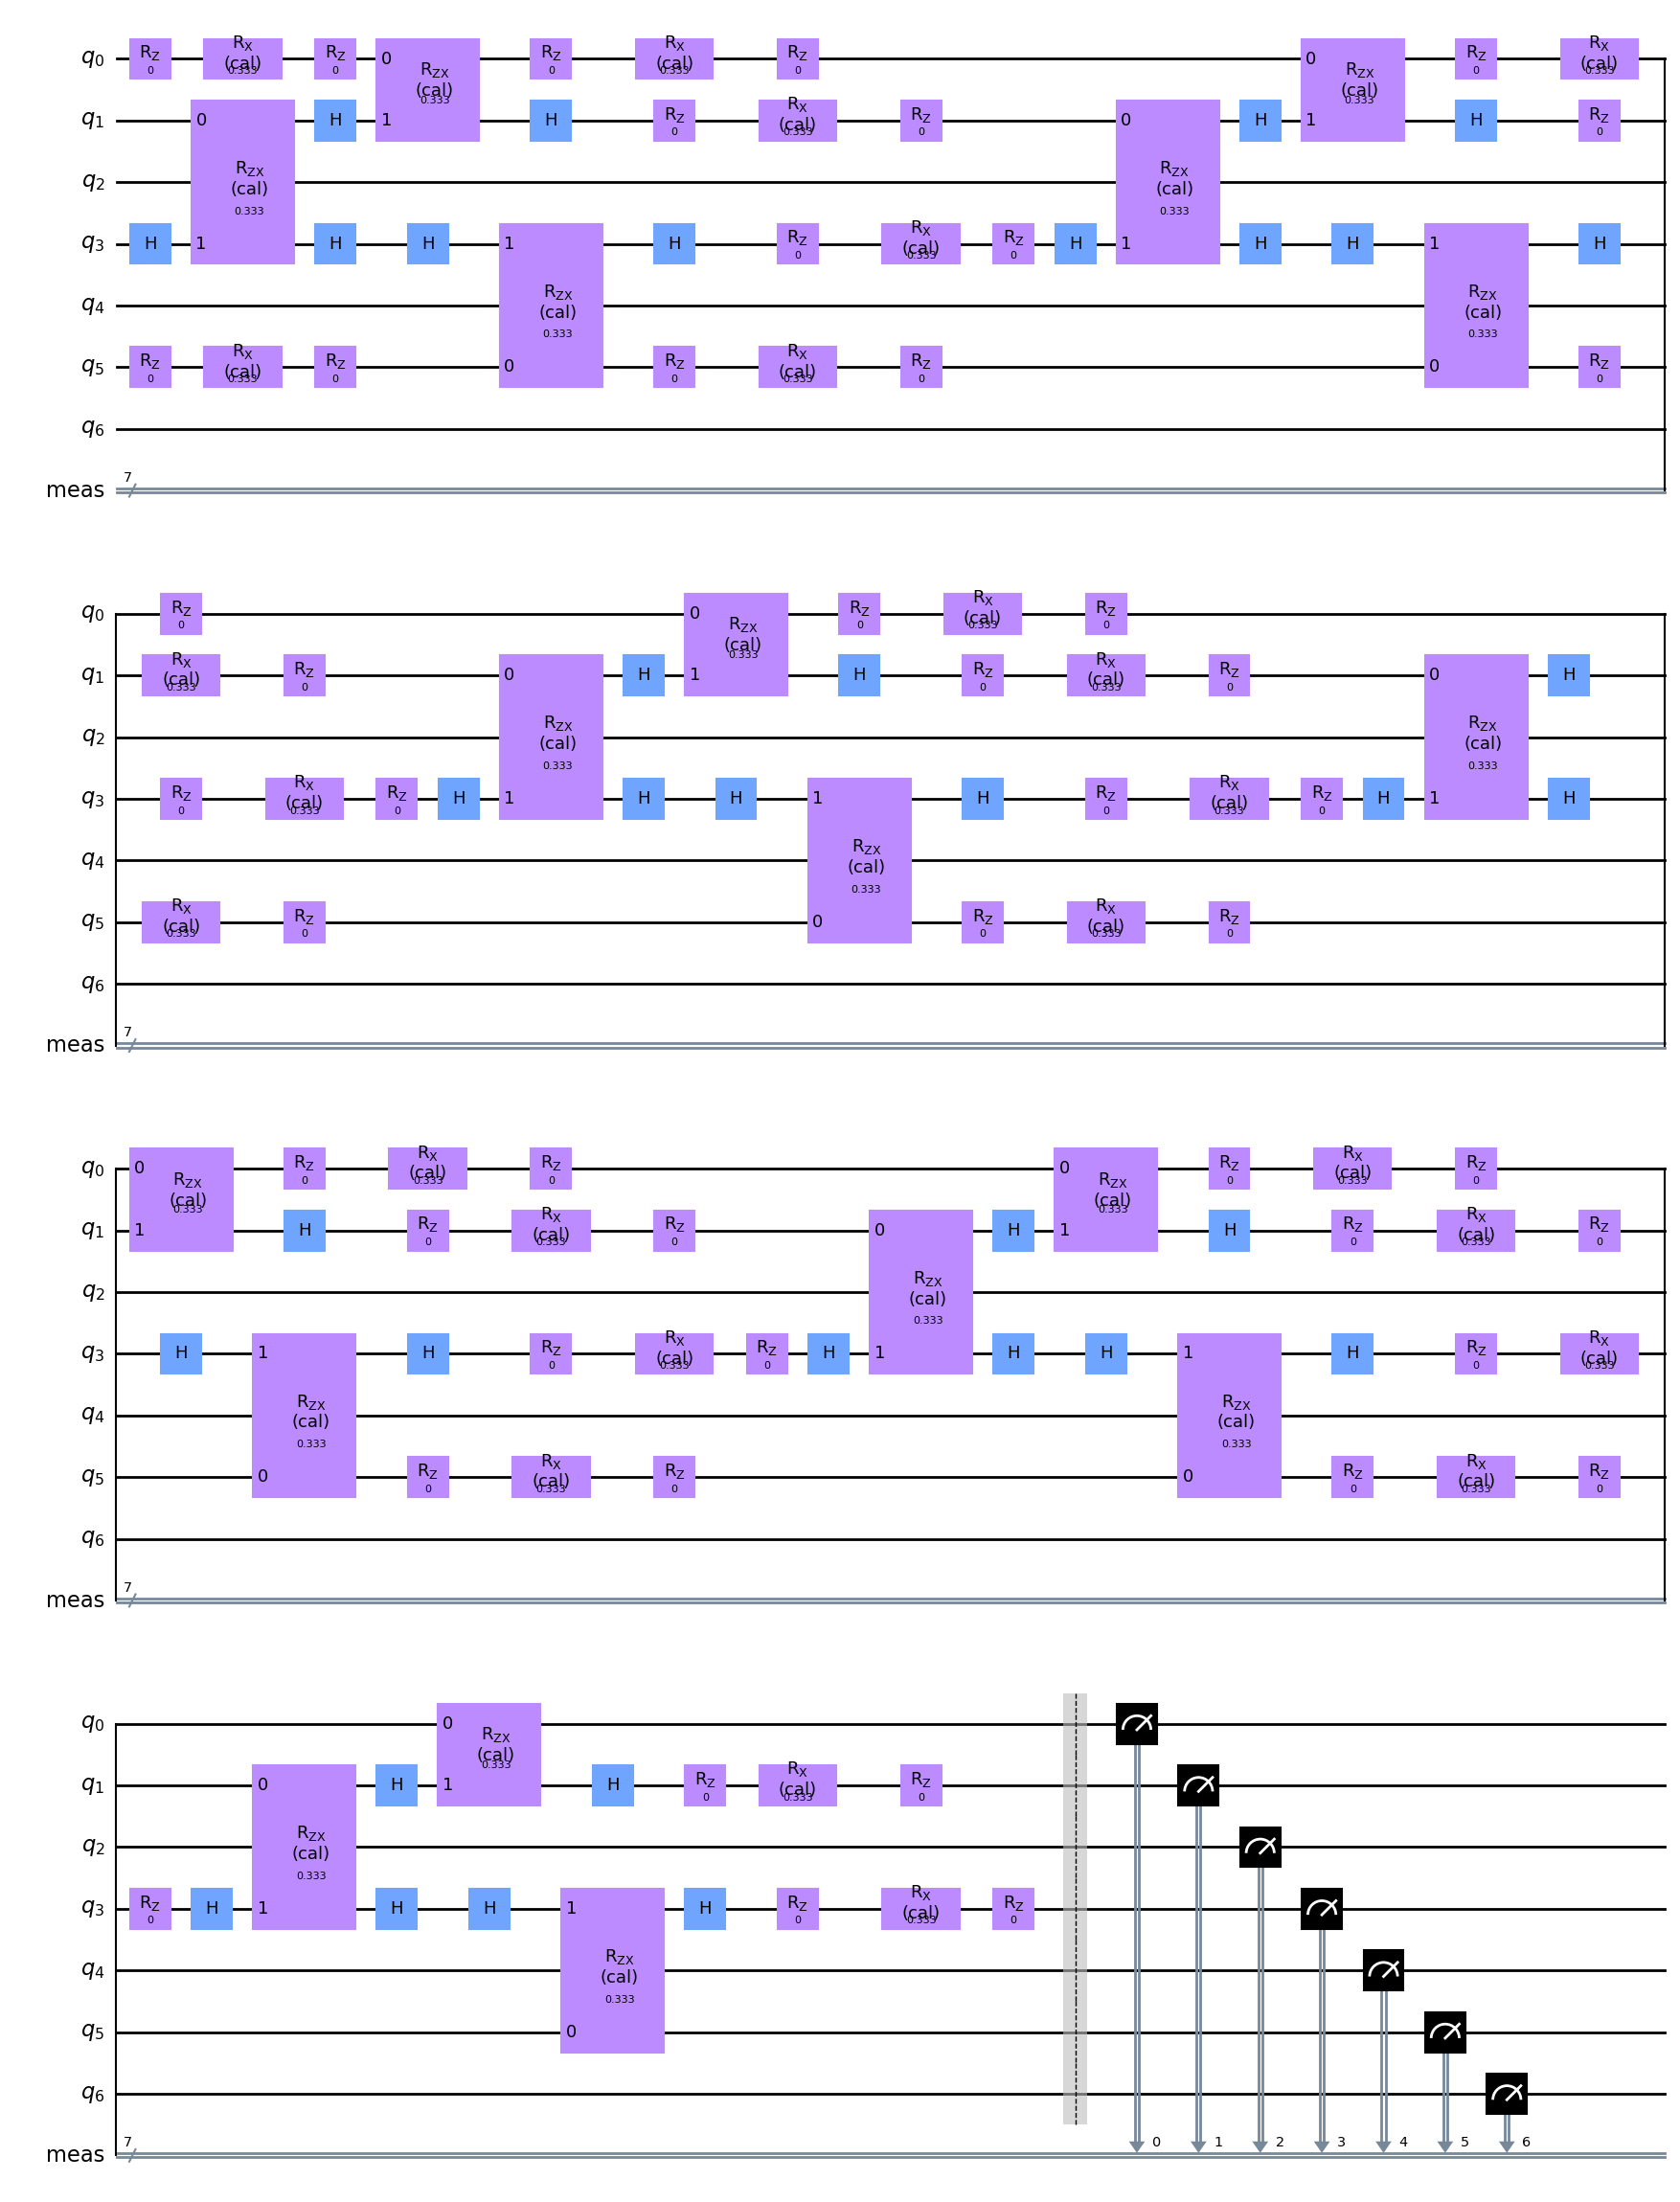

In [69]:
prog.draw('mpl')

In [58]:
from qiskit.visualization import plot_circuit_layout

plot_circuit_layout(prog,backend)

QiskitError: 'Circuit has no layout. Perhaps it has not been transpiled.'

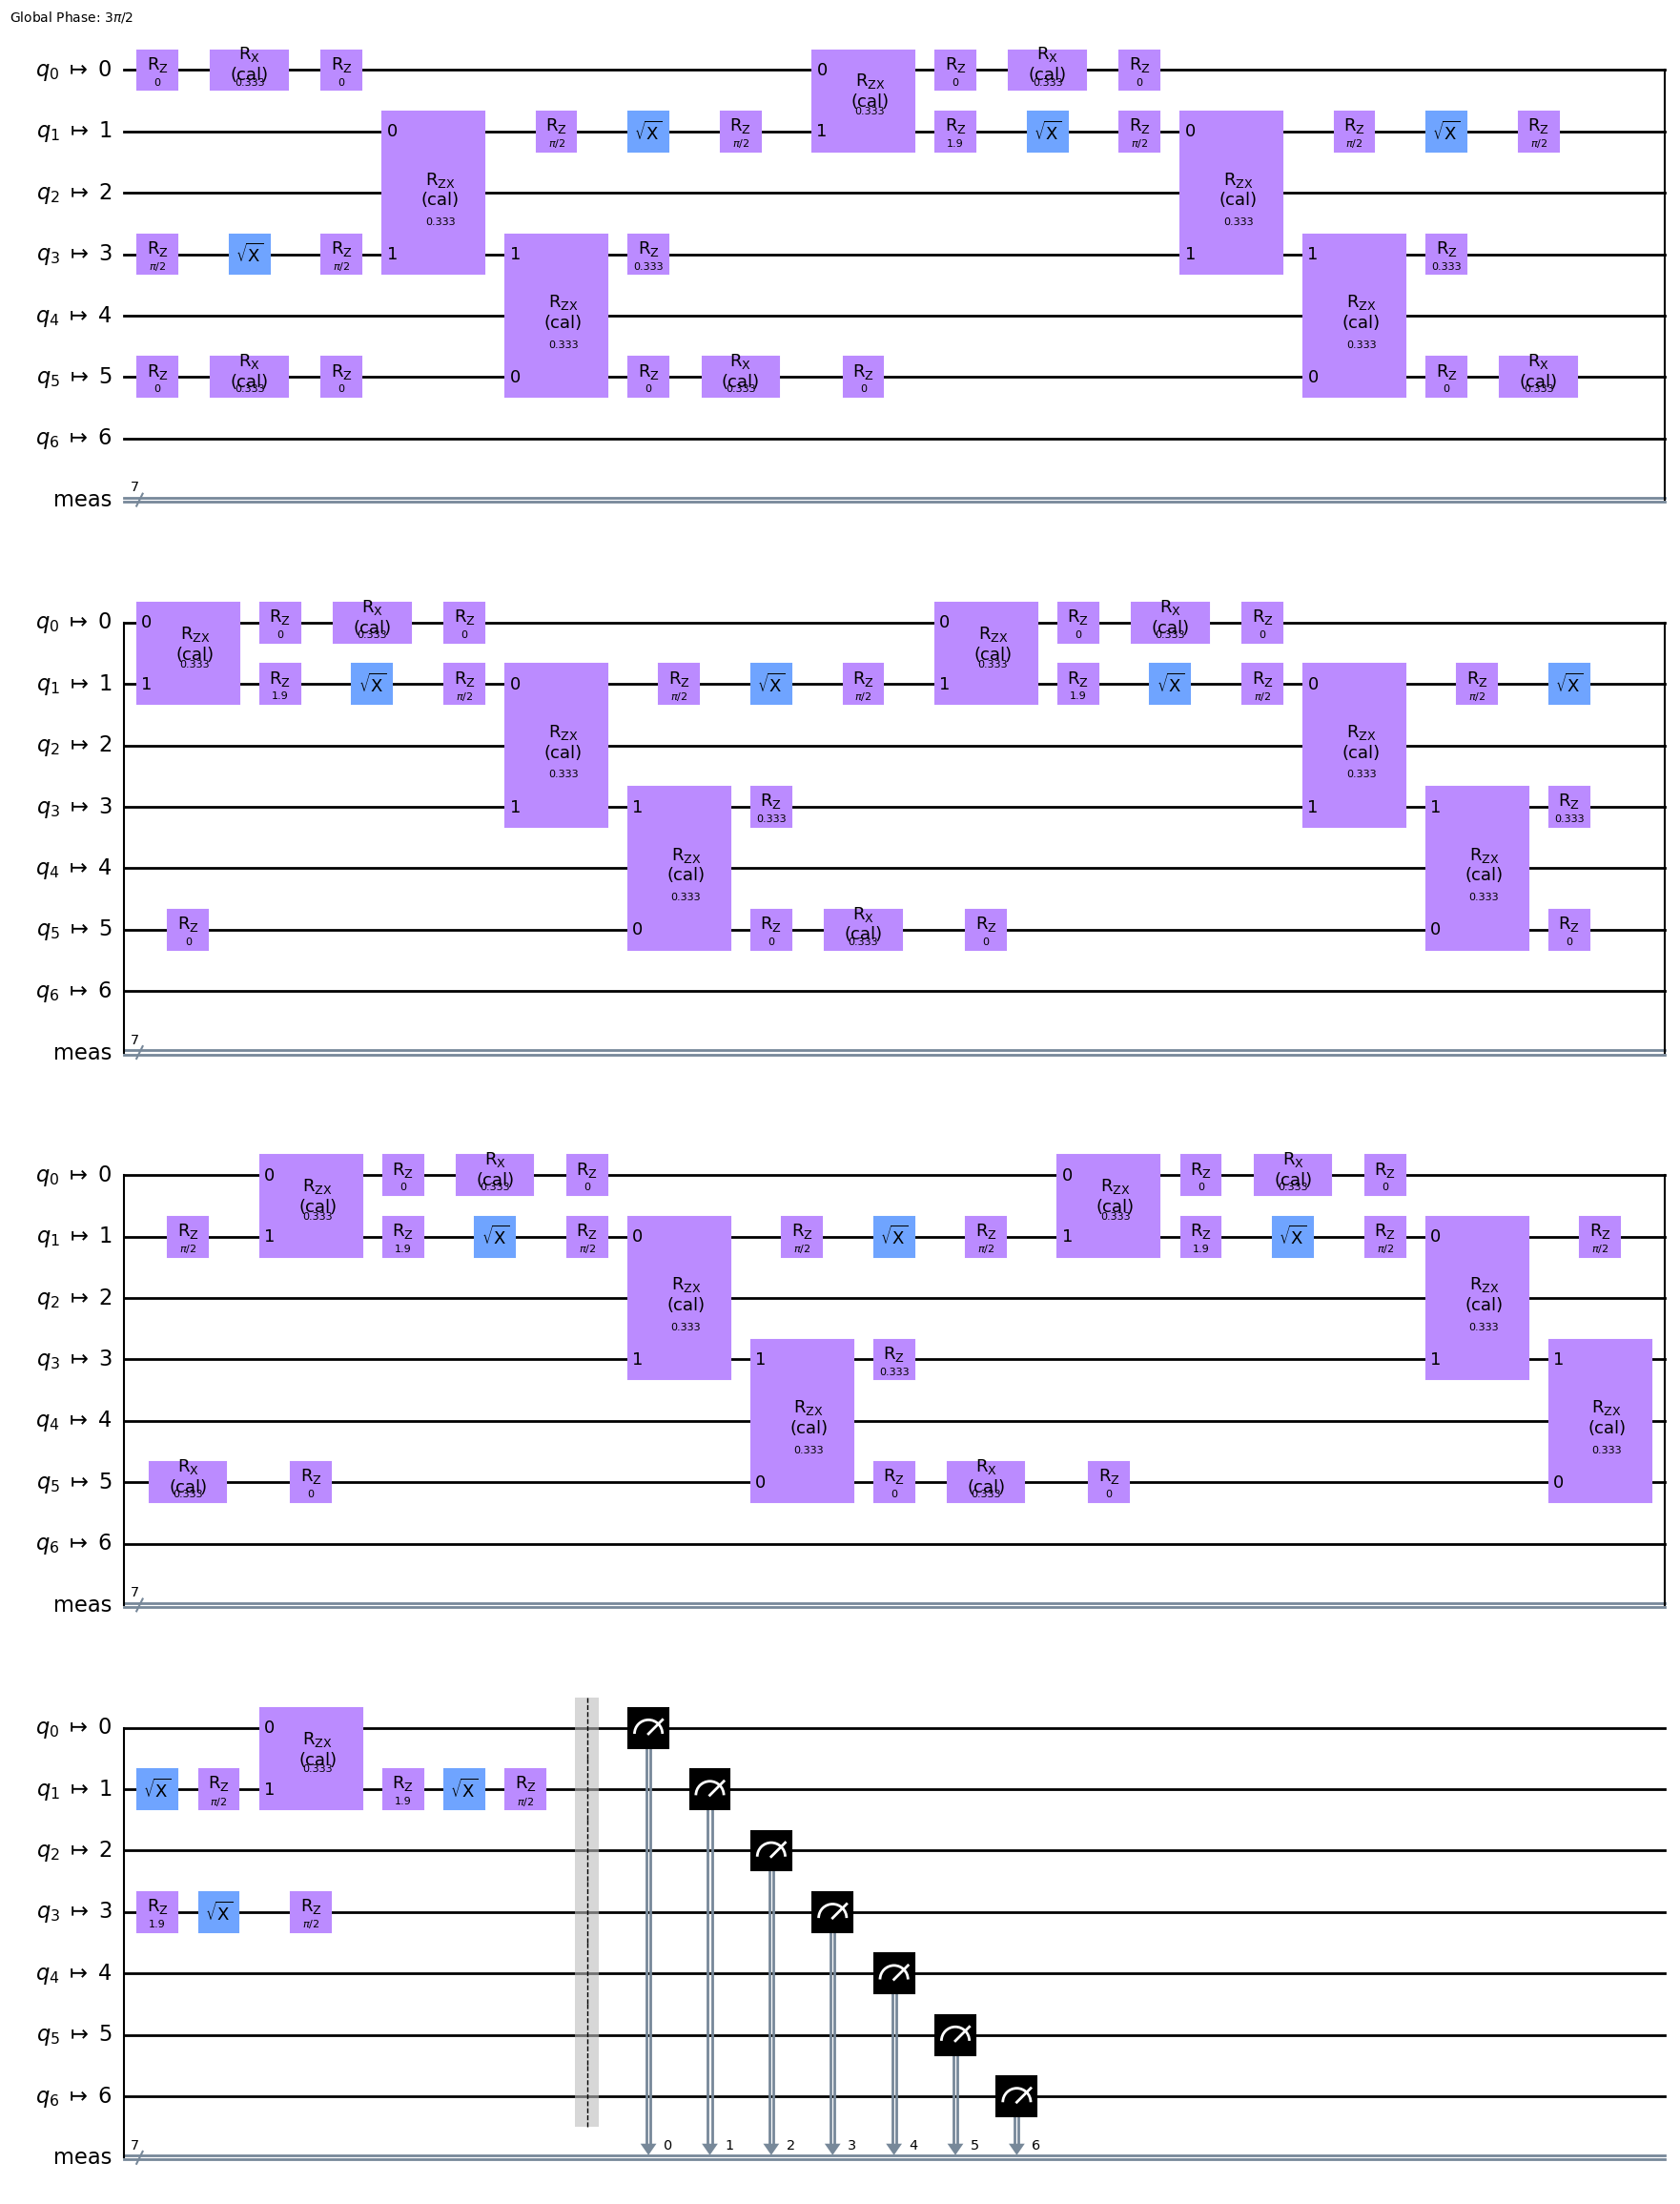

In [74]:
from qiskit import transpile as transpile_qiskit

transpiled_prog = transpile_qiskit(prog, backend=backend)

transpiled_prog.draw('mpl')

In [71]:
from qiskit import schedule as build_schedule

schedule = build_schedule(transpiled_prog,backend)

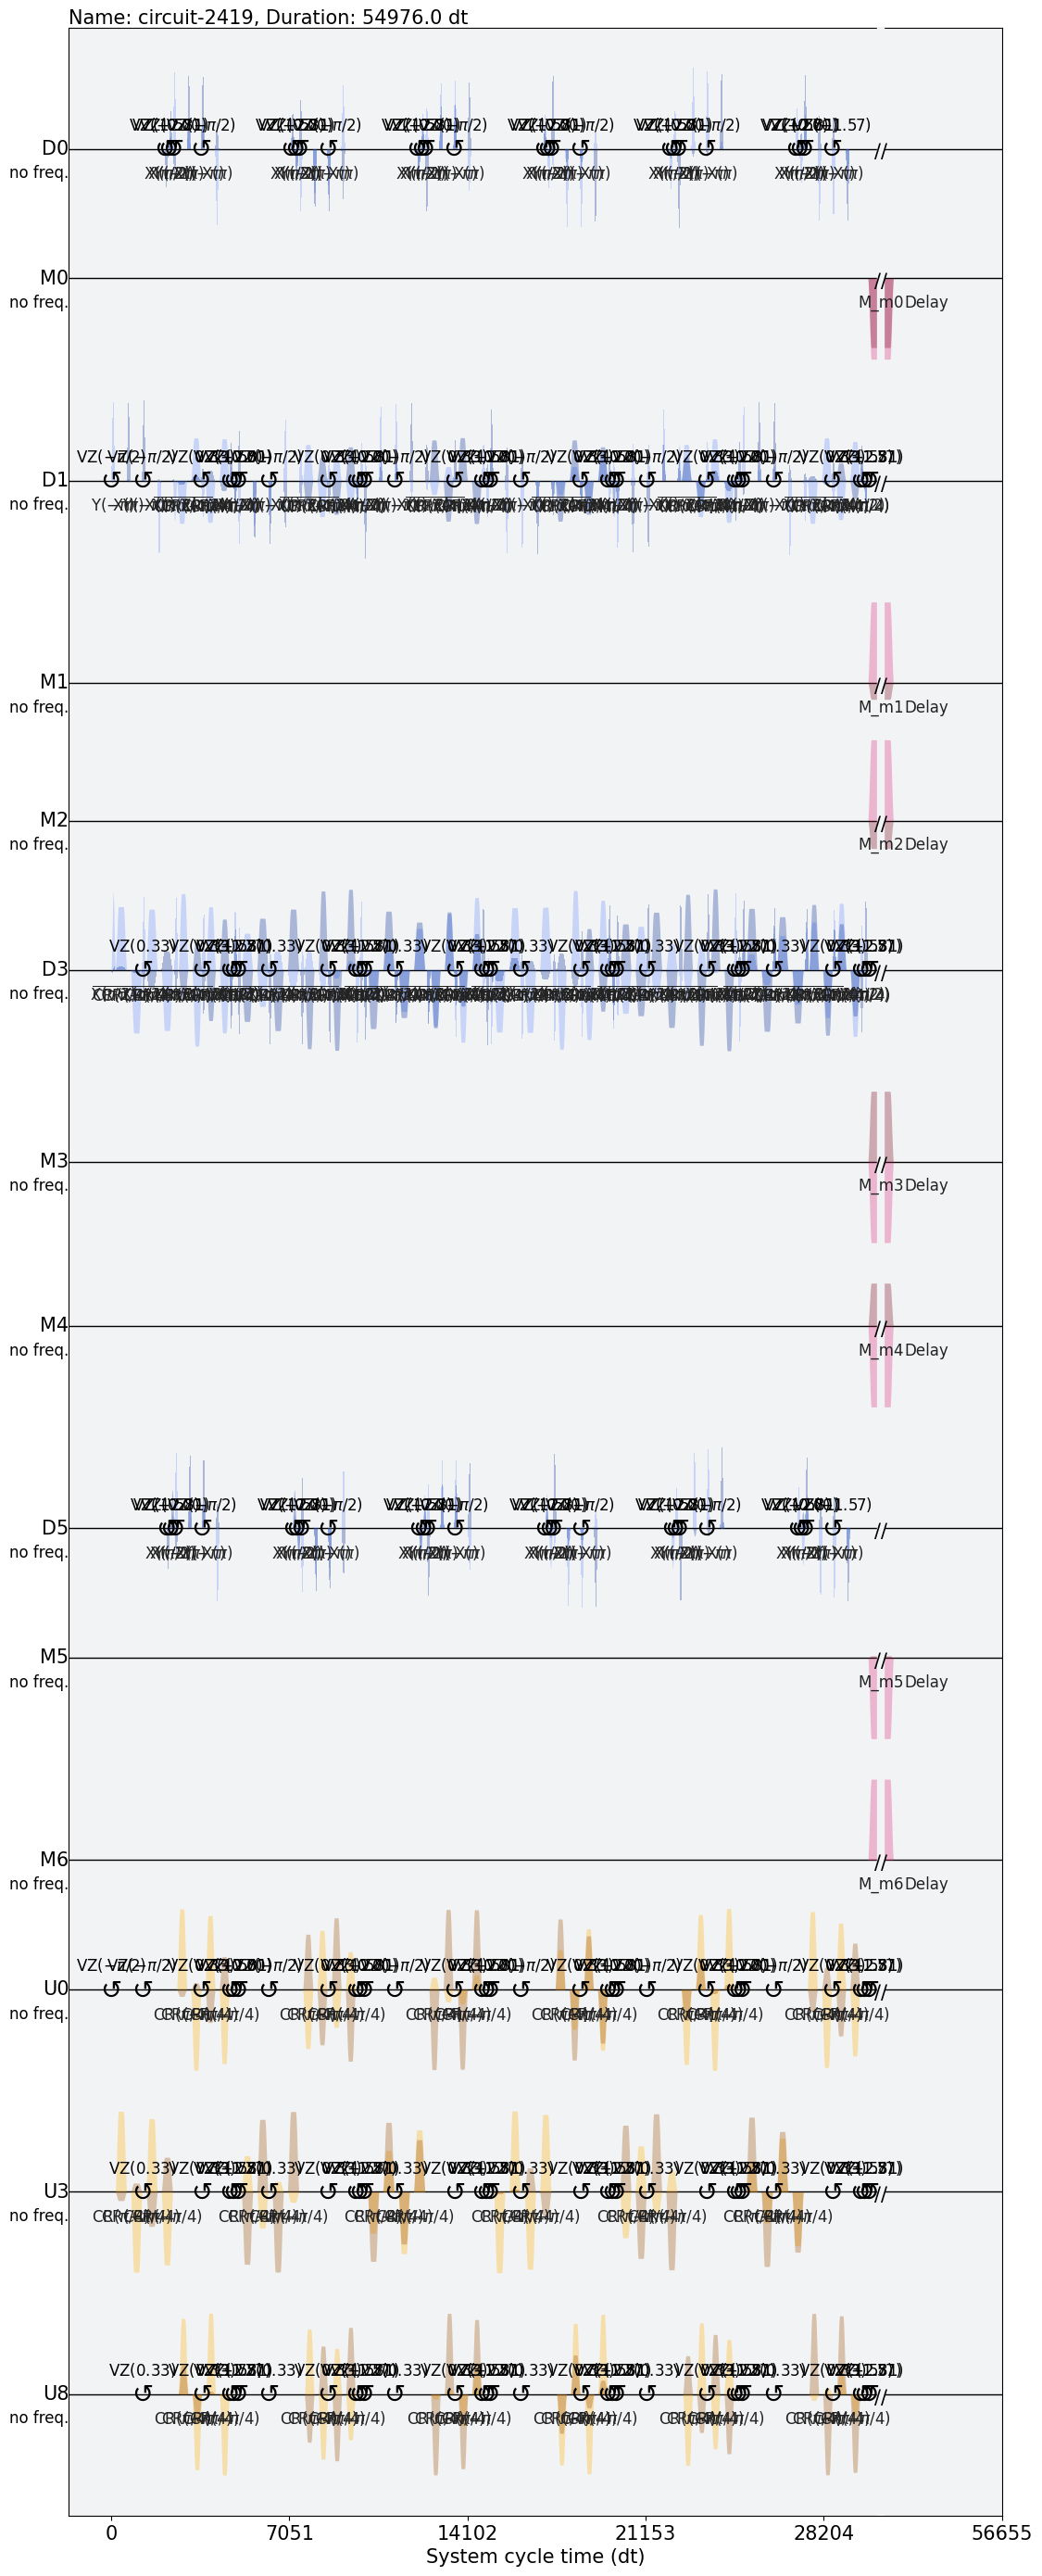

In [73]:
schedule.draw()

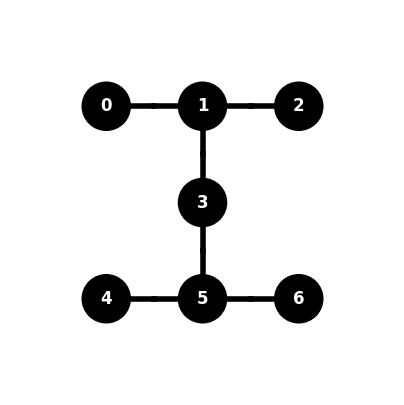

In [60]:
plot_circuit_layout(transpiled_prog,backend)

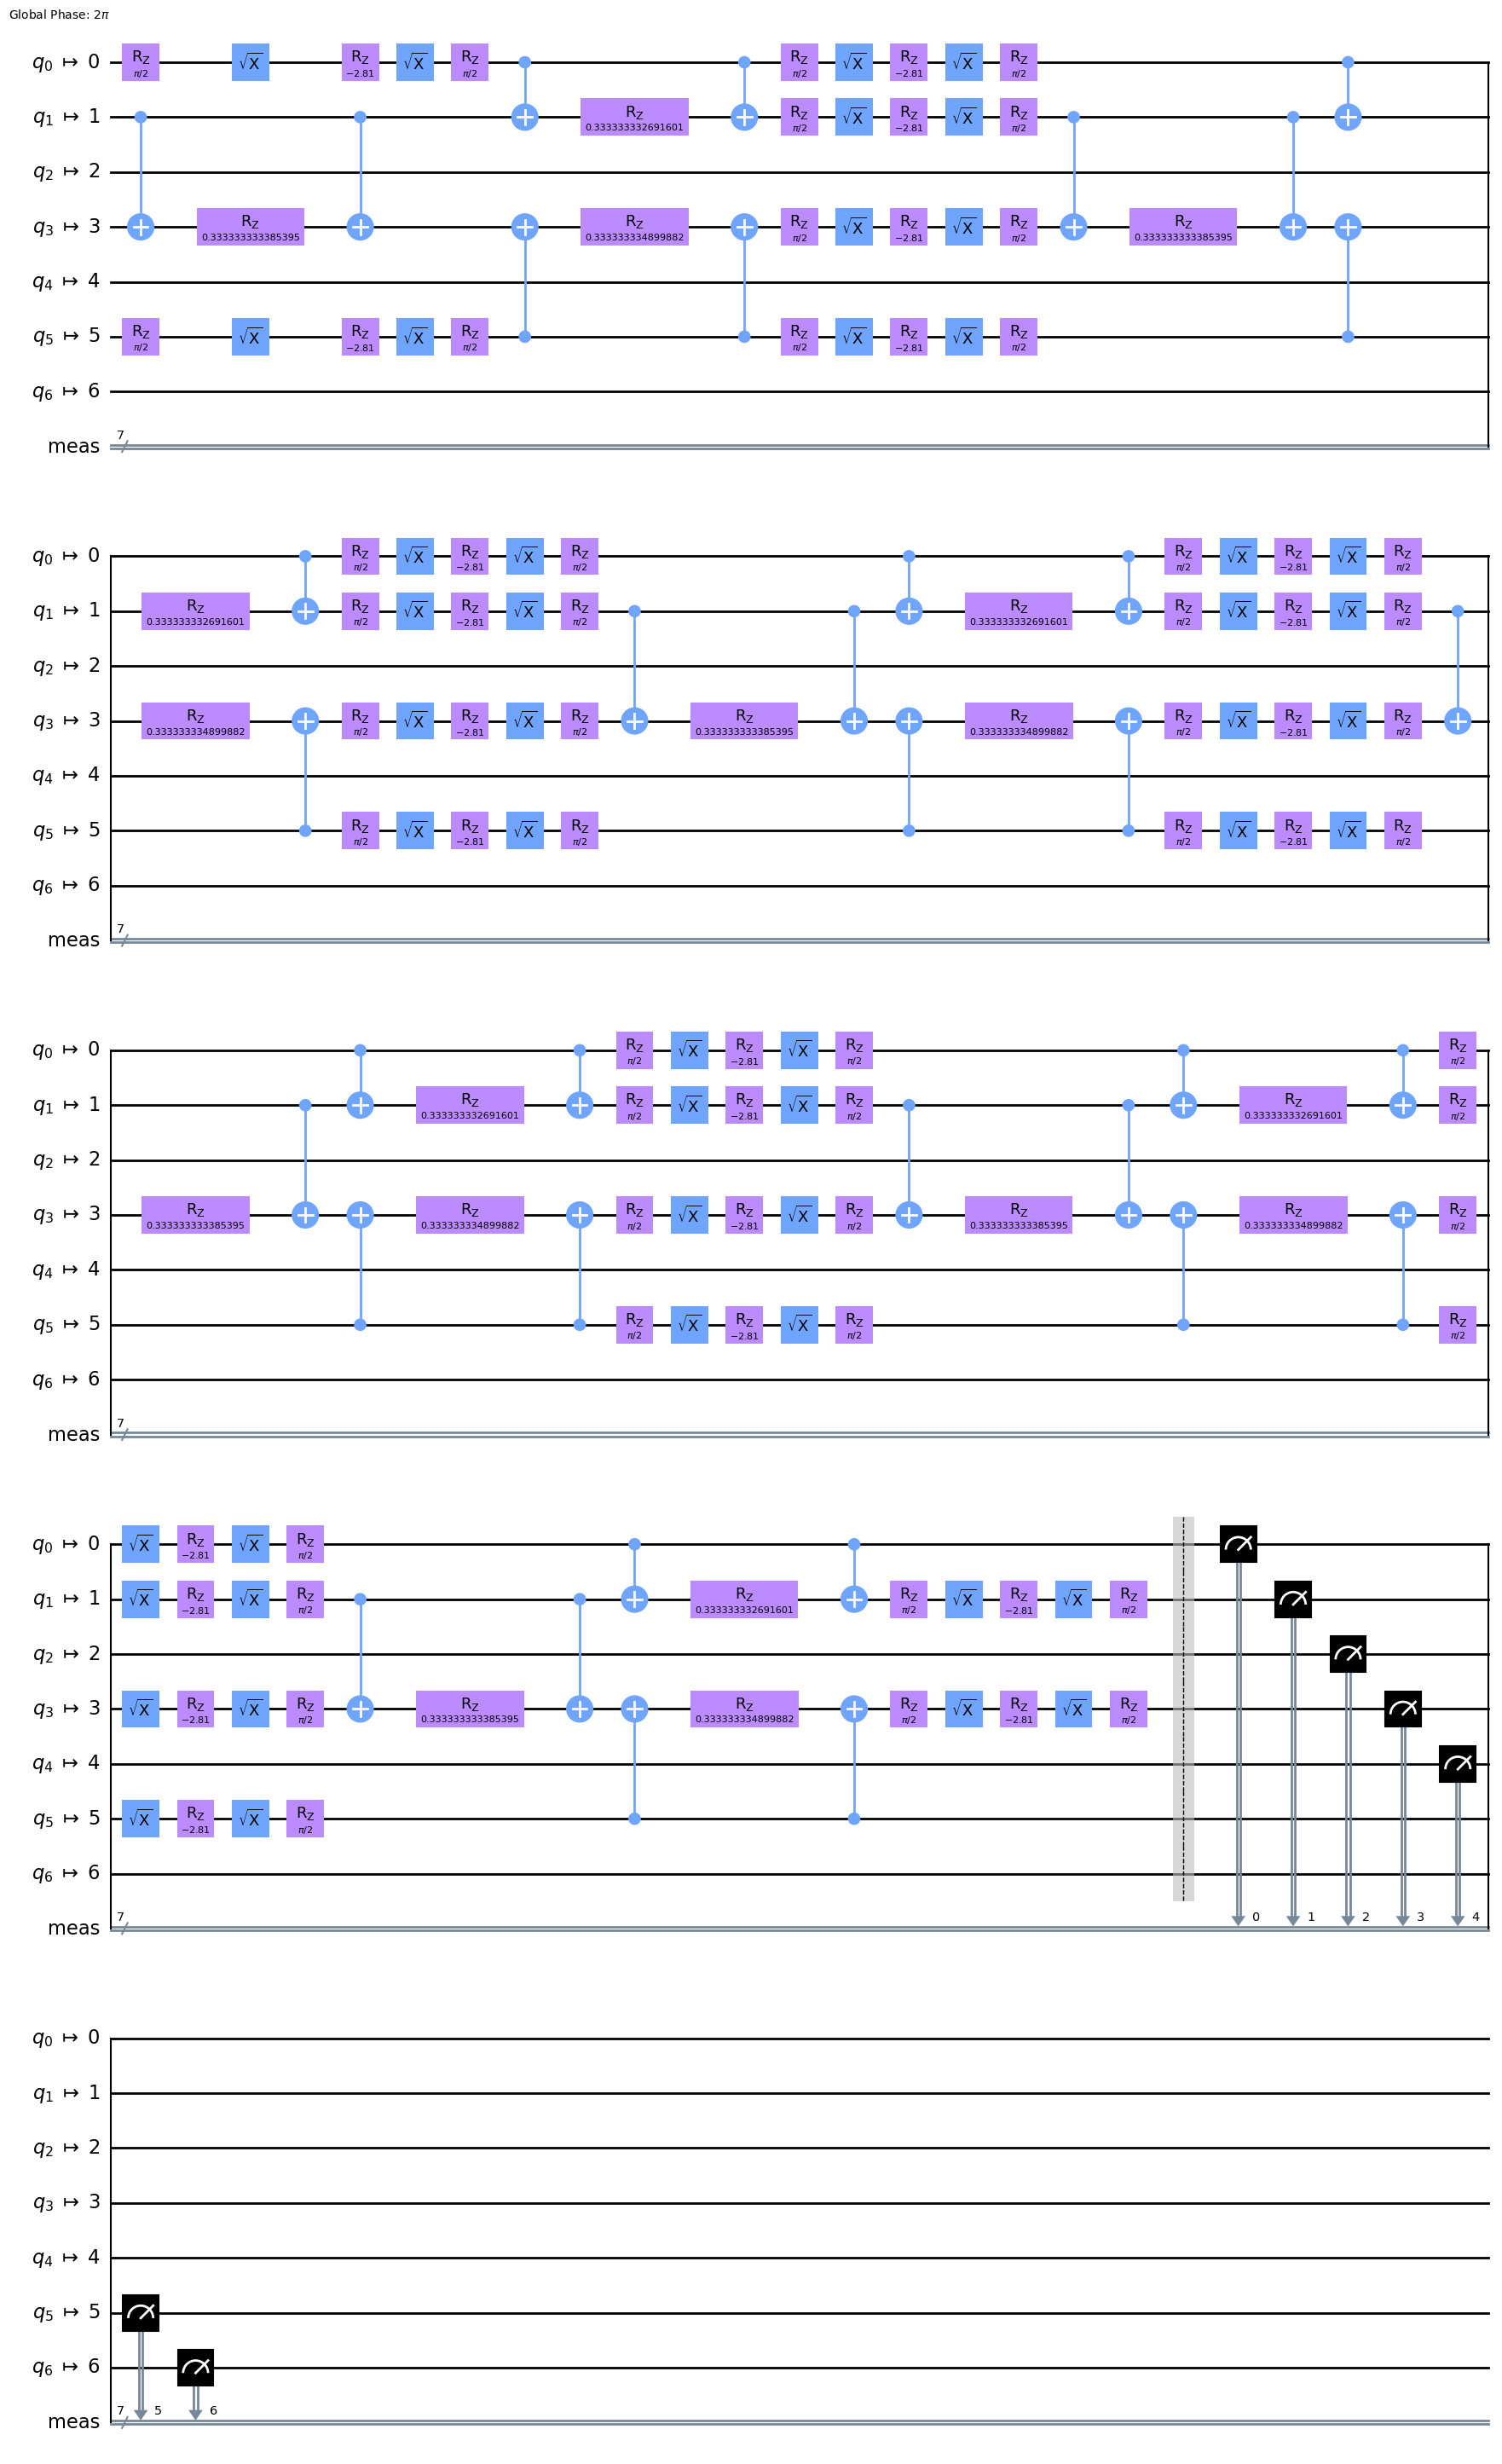

In [61]:
transpiled_prog = transpile_qiskit(prog, backend=backend,optimization_level=1)

plot_circuit_layout(transpiled_prog,backend)
transpiled_prog.draw('mpl')

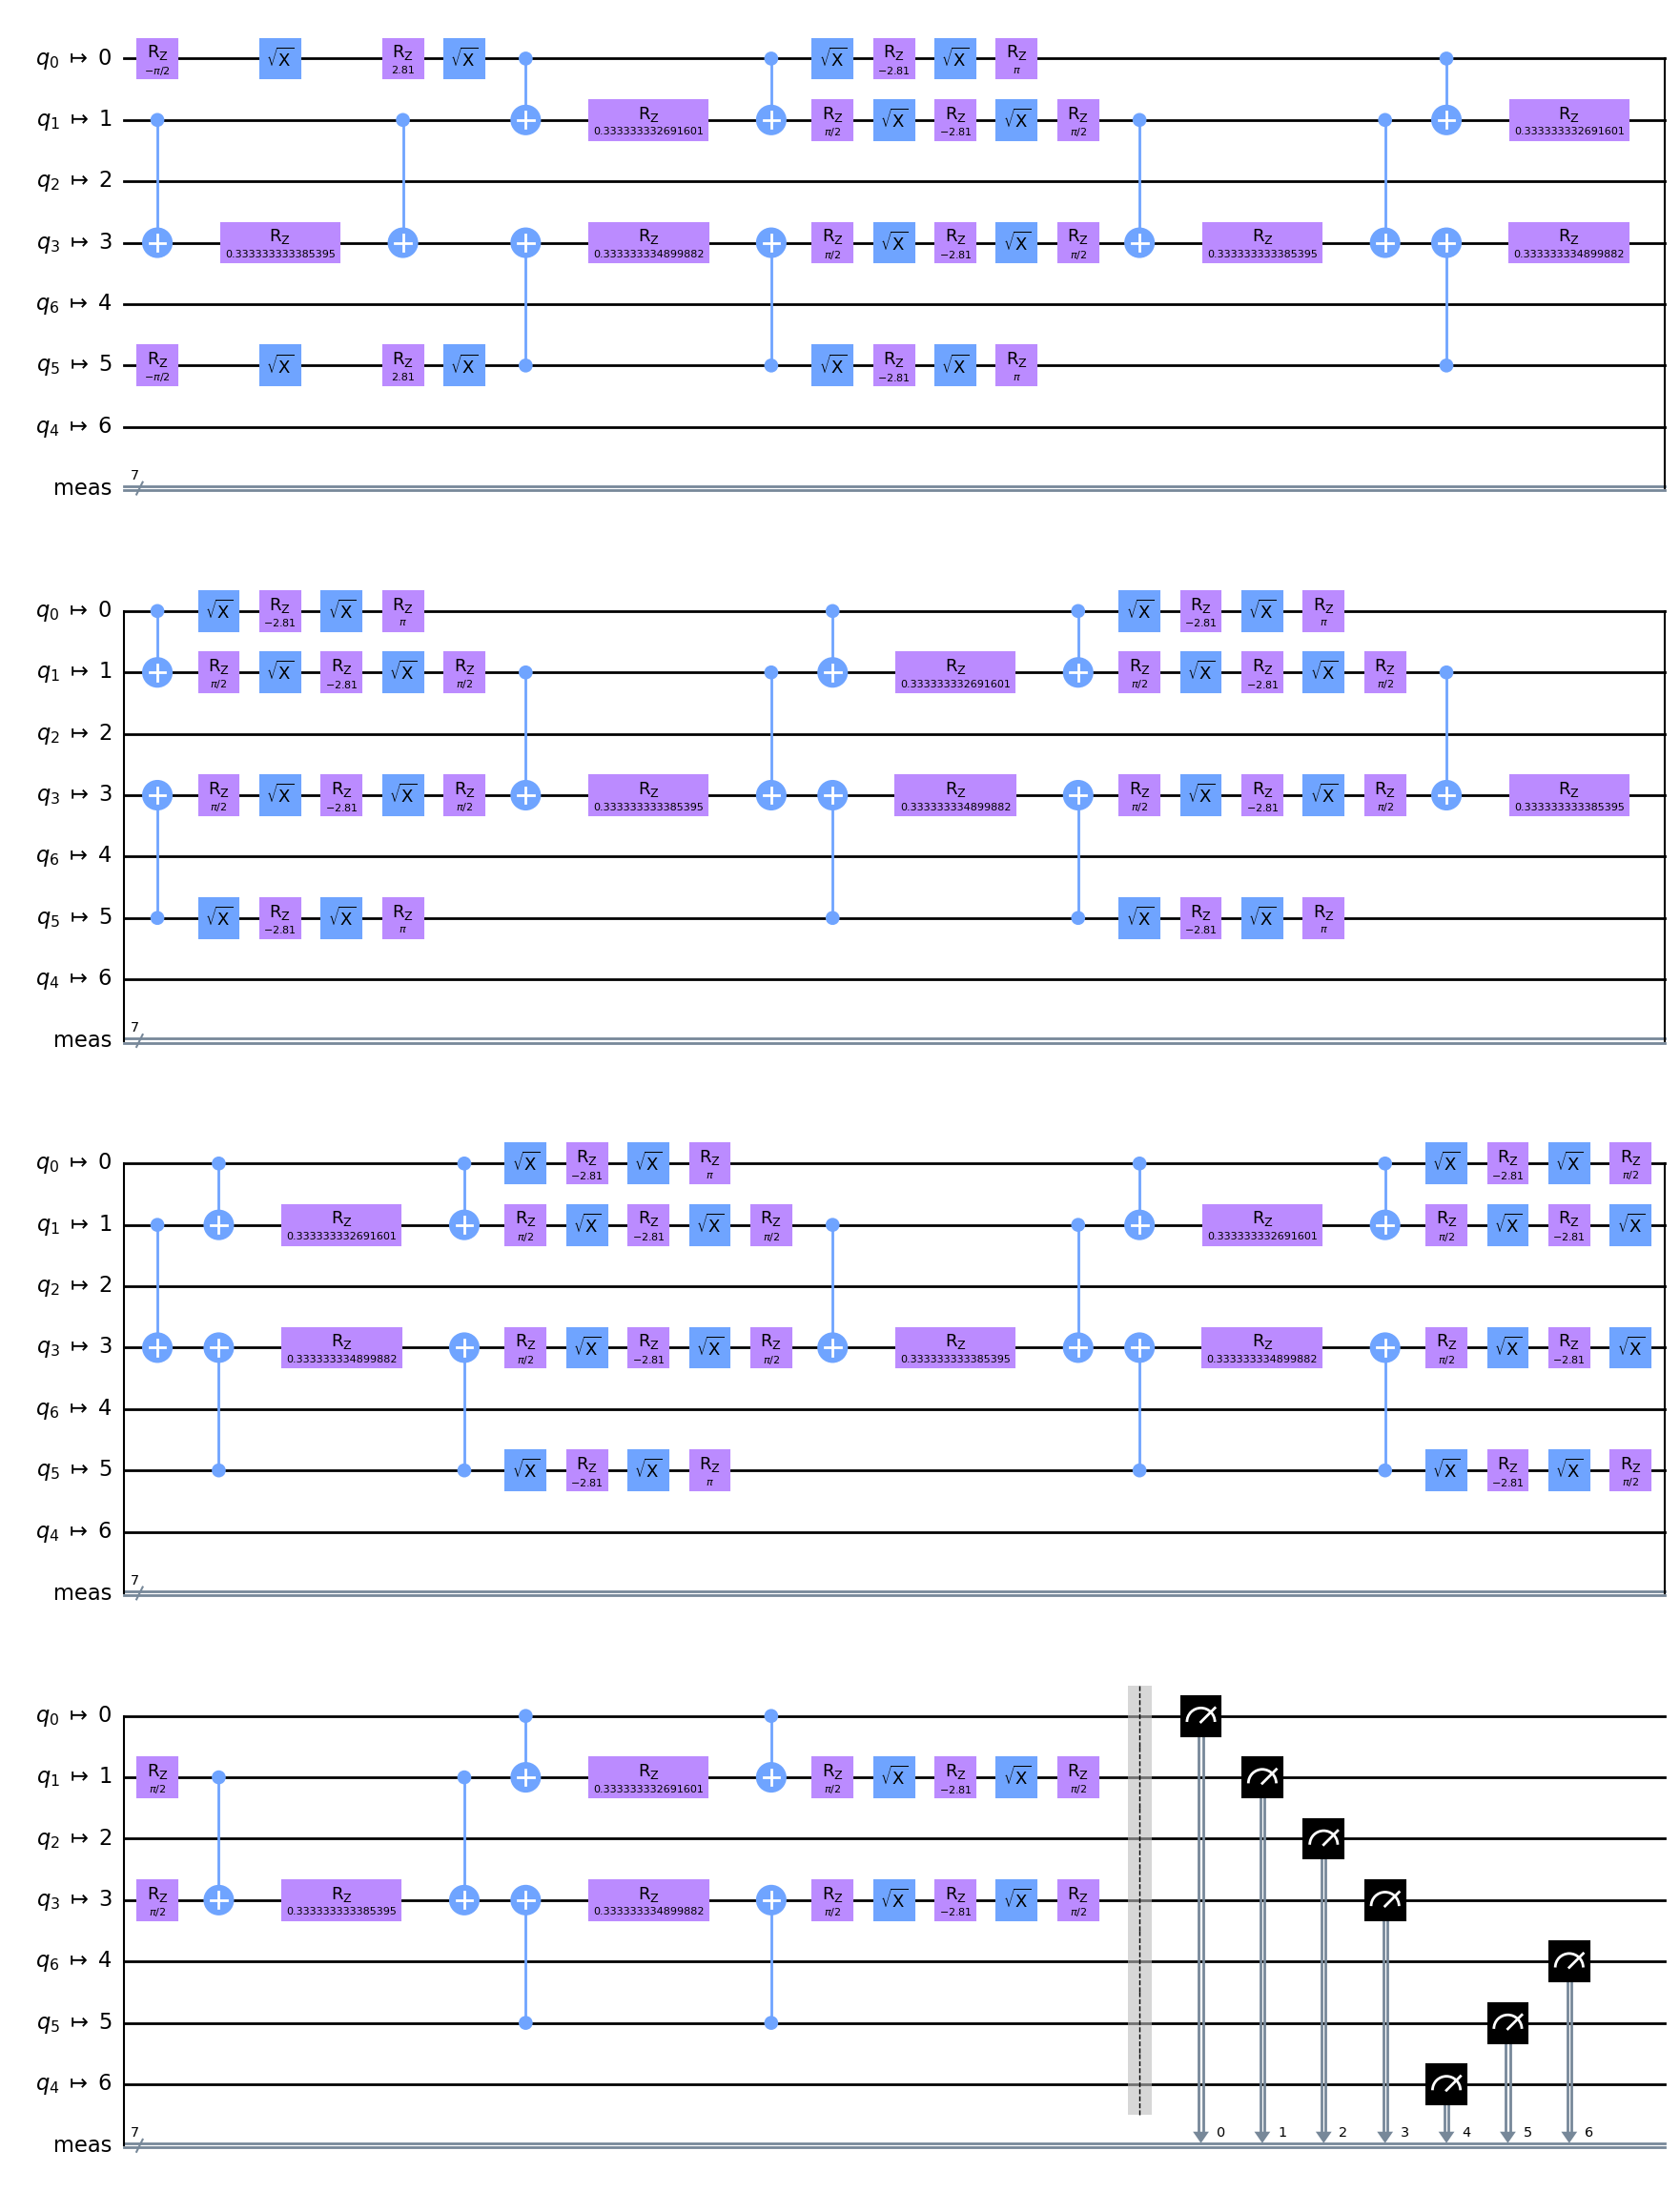

In [62]:
transpiled_prog = transpile_qiskit(prog, backend=backend,optimization_level=2)

plot_circuit_layout(transpiled_prog,backend)
transpiled_prog.draw('mpl')

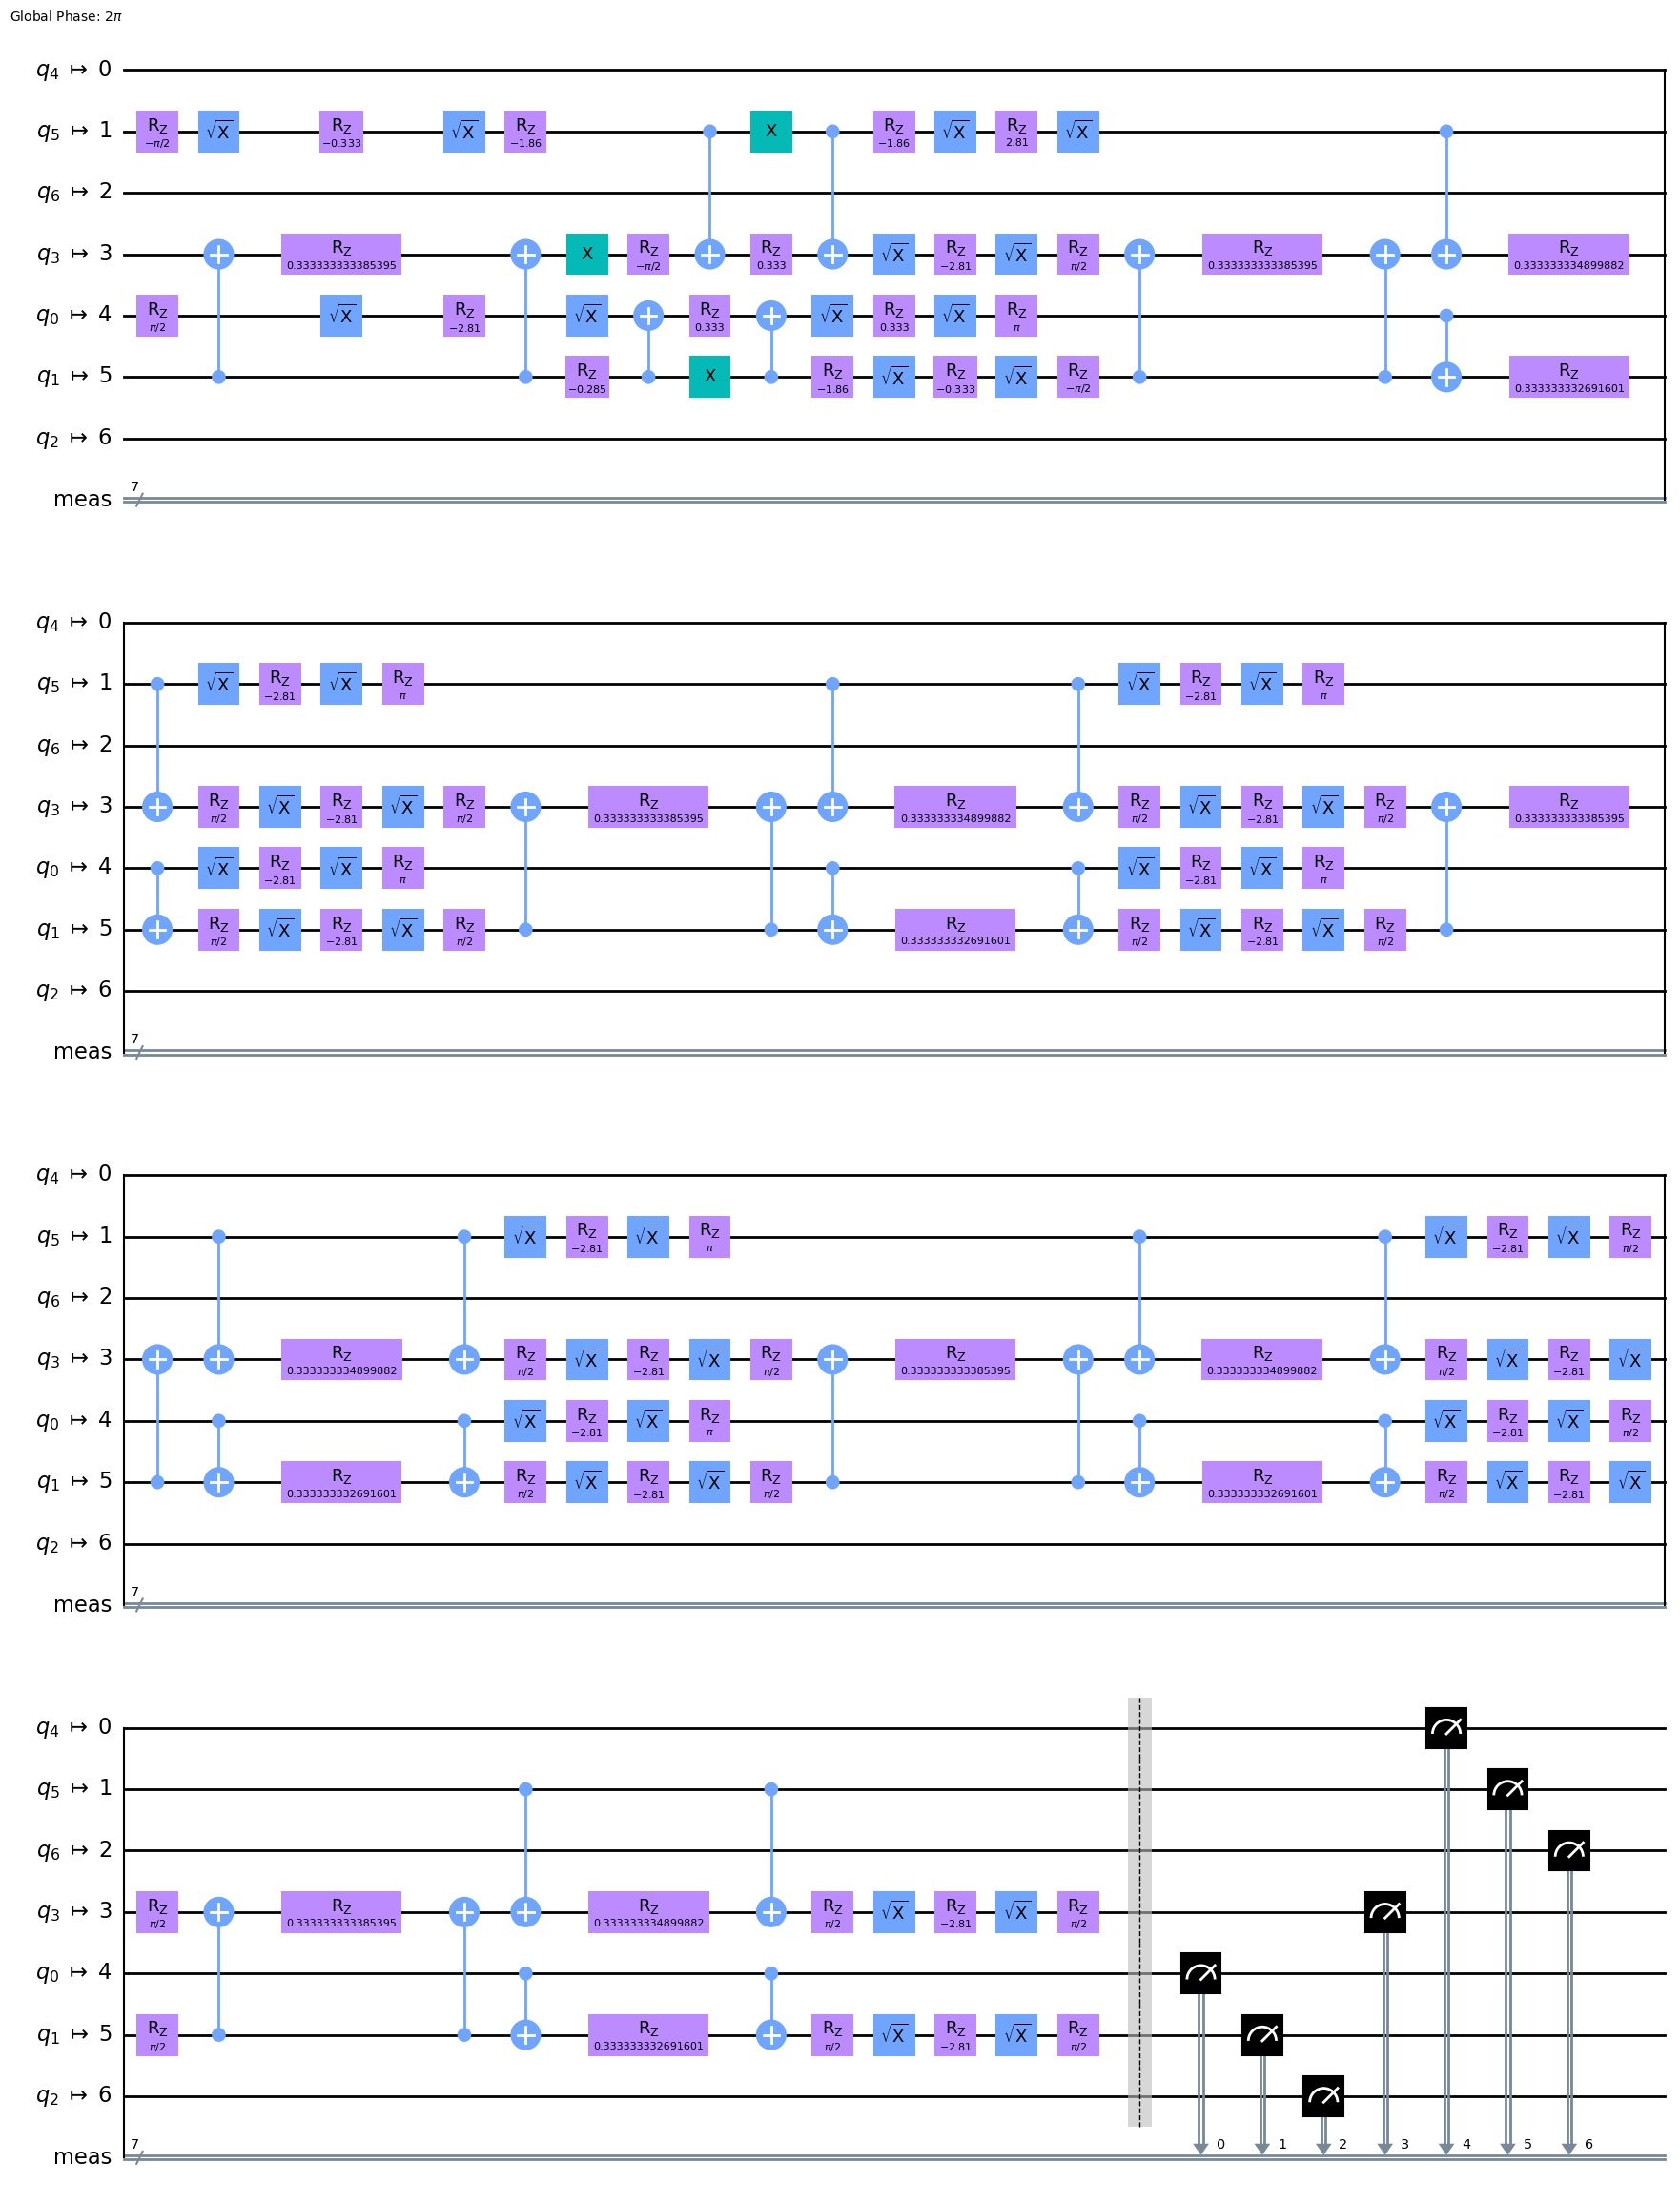

In [63]:
transpiled_prog = transpile_qiskit(prog, backend=backend,optimization_level=3)

plot_circuit_layout(transpiled_prog,backend)
transpiled_prog.draw('mpl')

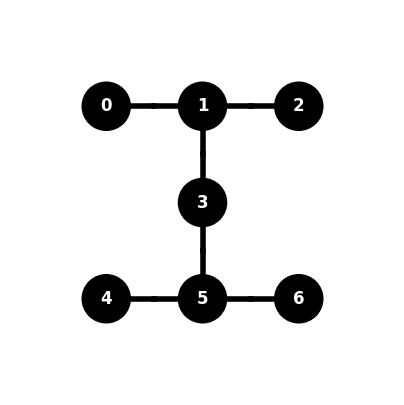

In [64]:
transpiled_prog = transpile_qiskit(prog, backend=backend,optimization_level=None)

plot_circuit_layout(transpiled_prog,backend)

In [ ]:
layout = layout
qs_names = qs.print_sites()
if state_prep is not None:
    prog = prog.compose(state_prep, qubits=layout, front=True)